<a href="https://colab.research.google.com/github/deepakrana123us/melanoma-detection/blob/main/Deepak_Rana_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing Skin Cancer Data
To do: Take necessary actions to read the data

# Importing all the important libraries

Import all the libararies

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from keras import layers, models
from keras.layers import Conv2D, MaxPooling2D # Import other layers you need
import warnings
warnings.filterwarnings("ignore")

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [5]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**
**Define some parameters for the loader**

In [7]:
## Write your train dataset here

batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Create a code to visualize one instance of all the nine classes present in the dataset


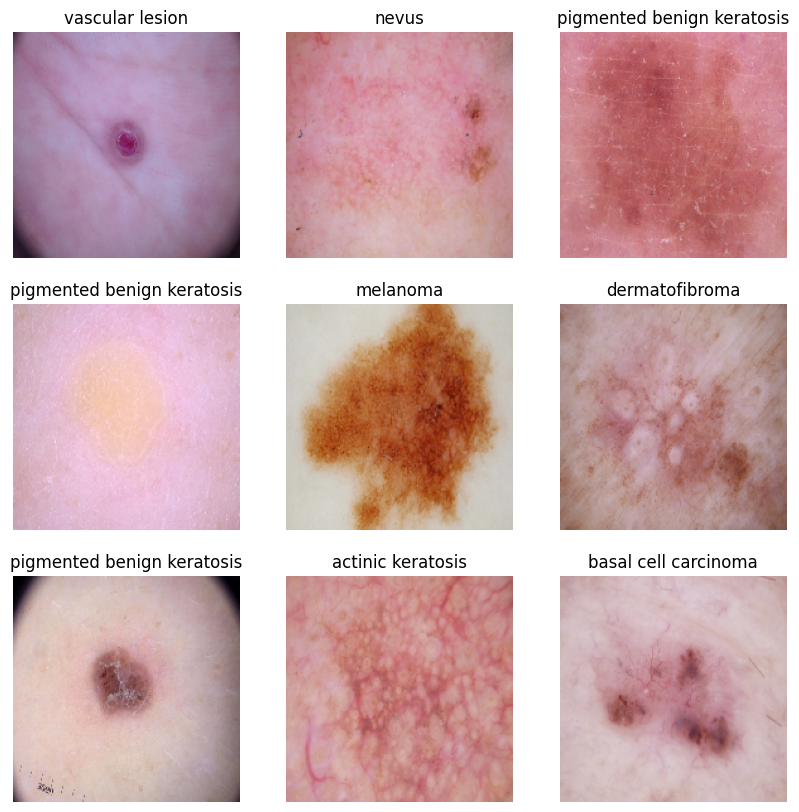

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**Create the CNN model**


In [14]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 221s 859ms/step - accuracy: 0.2056 - loss: 5.2049 - val_accuracy: 0.2819 - val_loss: 1.9537
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 63ms/step - accuracy: 0.3849 - loss: 1.7178 - val_accuracy: 0.5213 - val_loss: 1.4996
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4844 - loss: 1.5228 - val_accuracy: 0.5280 - val_loss: 1.4449
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5468 - loss: 1.2757 - val_accuracy: 0.5280 - val_loss: 1.4187
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6006 - loss: 1.1641 - val_accuracy: 0.5213 - val_loss: 1.4291
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6522 - loss: 1.0018 - val_accuracy: 0.5078 - val_loss: 1.5622
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6834 - loss: 0.9143 - val_accuracy: 0.4922 - val_loss: 1.5975
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7092 - loss: 0.8096 - val_accuracy: 0.5213



**Choosing an appropriate data augmentation strategy to resolve underfitting/overfittin**g

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

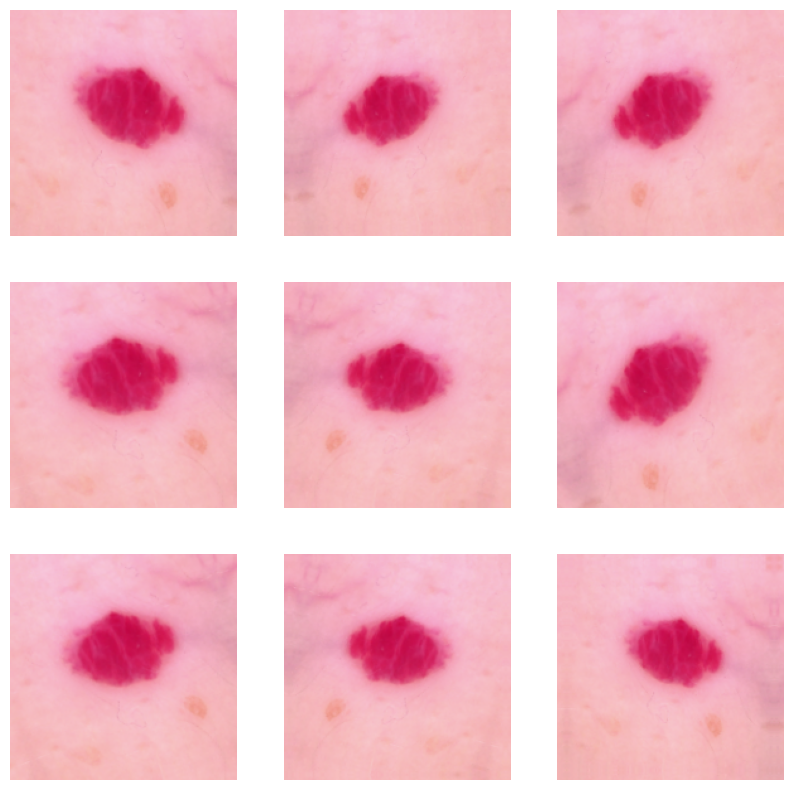

In [18]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Model Building & training on the augmented data :**
Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [19]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [20]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.1980 - loss: 5.6158 - val_accuracy: 0.3043 - val_loss: 1.8984
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3118 - loss: 1.8678 - val_accuracy: 0.4430 - val_loss: 1.7134
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.4108 - loss: 1.6672 - val_accuracy: 0.4832 - val_loss: 1.5150
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.4472 - loss: 1.5277 - val_accuracy: 0.4720 - val_loss: 1.5529
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.4828 - loss: 1.4598 - val_accuracy: 0.4787 - val_loss: 1.5000
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.4718 - loss: 1.4196 - val_accuracy: 0.4877 - val_loss: 1.4862
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.4945 - loss: 1.3711 - val_accuracy: 0.5347 - val_loss: 1.4185
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5331 - loss: 1.3424 - val_accuracy: 0.5257 

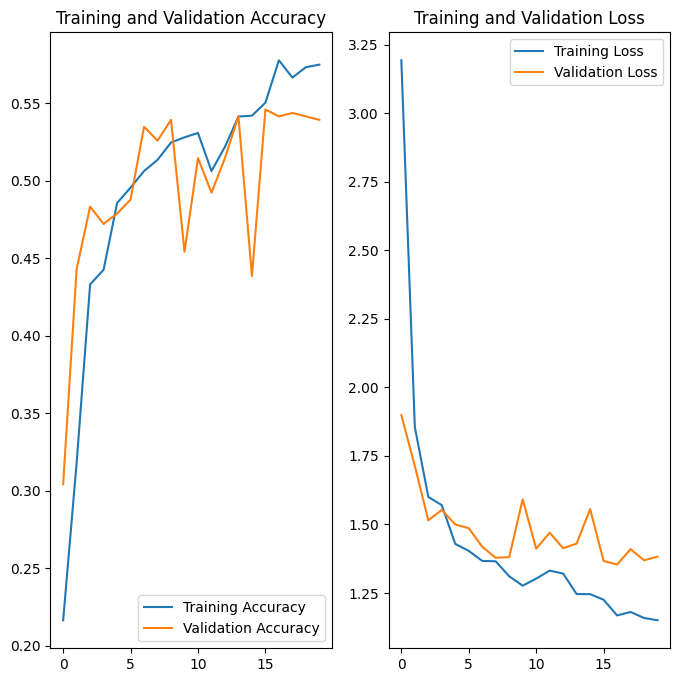

In [22]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings :**
As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
As the training loss decreases with epochs the validation loss decreases and stalls.
The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

**Model Building & training on the augmented data with dropout :**
Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
Choosing an appropriate optimiser and loss function for model training


In [23]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [24]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.1964 - loss: 6.7308 - val_accuracy: 0.3691 - val_loss: 1.7197
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.3556 - loss: 1.7482 - val_accuracy: 0.4720 - val_loss: 1.5386
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.4743 - loss: 1.4688 - val_accuracy: 0.5302 - val_loss: 1.4600
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.5119 - loss: 1.4079 - val_accuracy: 0.5280 - val_loss: 1.4160
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.5224 - loss: 1.4468 - val_accuracy: 0.5302 - val_loss: 1.4358
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.5117 - loss: 1.3653 - val_accuracy: 0.5213 - val_loss: 1.4838
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.5272 - loss: 1.3844 - val_accuracy: 0.5414 - val_loss: 1.3909
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.5542 - loss: 1.2944 - val_accuracy

**Findings :**
As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
As the training loss decreases with epochs the validation loss decreases
The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
The difference in accuracy between training and validation accuracy is very less

We can clearly see that the overfitting of the model has redused significantly when compared the earlier models
Class distribution:
Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.



In [26]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))


actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


In [27]:
!pip install Augmentor


# Handling class imbalances:
  Rectifing class imbalances present in the training dataset with Augmentor library.




In [32]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78C734291F10>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7343B7C90>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7341A7790>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78C720013690>: 100%|██████████| 500/500 [01:21<00:00,  6.17 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78C7342B2DD0>: 100%|██████████| 500/500 [01:21<00:00,  6.16 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C723924090>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78C73C299B10>: 100%|██████████| 500/500 [00:39<00:00, 12.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78C7343532D0>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C734699F90>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


# **Handling class imbalances:**
Rectifing class imbalances present in the training dataset with Augmentor library.

In [38]:
import glob

In [39]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [47]:
# extracting the augmented image paths in a list
# Import the glob module

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_93287ea9-33e5-4703-be02-646fc5ccce63.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_17e91529-d4e9-4cc5-a470-32c5cf3096c6.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_dfd9ee17-d10e-4bda-874a-c51f8a676b4c.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_76053aaa-e215-4ce6-afa2-fd0761c4d493.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_3246647a

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [48]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [49]:
df['Label'].value_counts()


,count
Label,
actinic keratosis,500
pigmented benign keratosis,500
vascular lesion,500
melanoma,500
dermatofibroma,500
nevus,500
basal cell carcinoma,500
seborrheic keratosis,500
squamous cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [50]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [51]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training on the rectified class imbalance data :
Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
Choosing an appropriate optimiser and loss function for model training
Training the model for ~30 epochs
Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [55]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [56]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

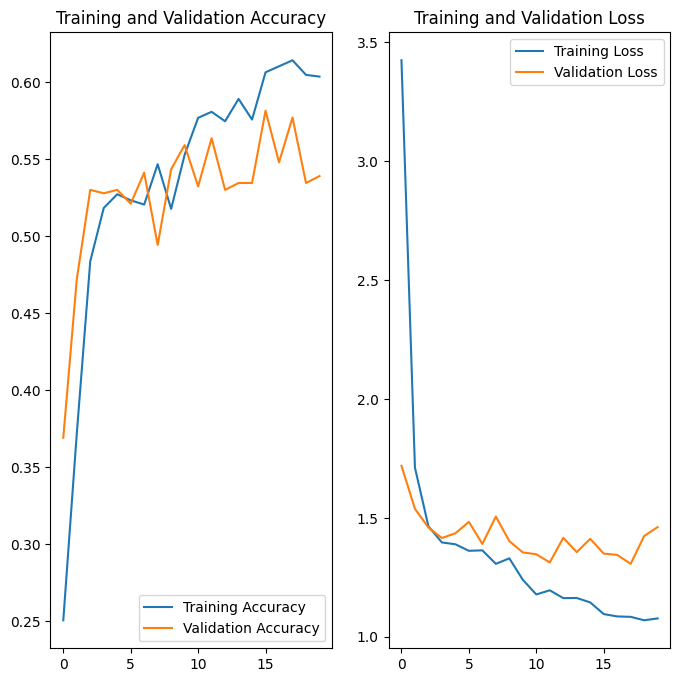

In [57]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

## Findings :
As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.

As the training loss decreases with epochs the validation loss also decreases.

The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 75% accuracy on the validation set.

The difference in accuracy between training and validation accuracy is very less